# Audio

## Task 1

Для начала познакомимся с этими записями. \
Установи библиотеку [librosa](https://librosa.org/). Это популярная библиотека для работы с аудио.
Визуализируй аудио сигнал файла `0_1_0_1_1_1_0_0.wav` с помощью функции [librosa.display.waveshow](https://librosa.org/doc/main/generated/librosa.display.waveshow.html)
График должен быть такой же, как показано ниже (по значениям):

![waveform](../misc/images/waveform.png)
>Для того, чтобы прослушать это аудио файл, можешь воспользоваться [IPython.display.Audio](http://ipython.org/ipython-doc/stable/api/generated/IPython.display.html#IPython.display.Audio)

In [1]:
%matplotlib inline  
import librosa
import librosa.display
import IPython
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import os

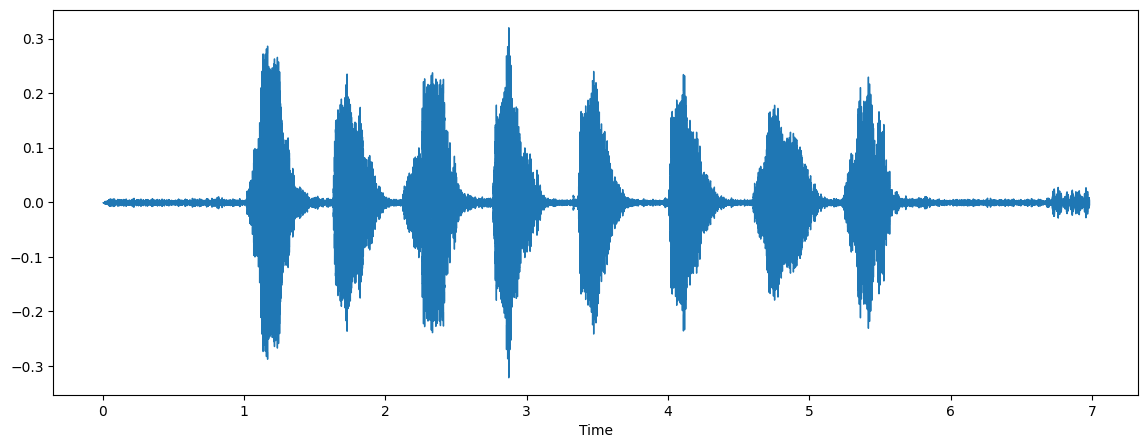

In [2]:
import IPython.display as ipd
audio_data = ('../datasets/waves_yesno 2/0_1_0_1_1_1_0_0.wav')
y, sr = librosa.load(audio_data, sr=None)

plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
ipd.Audio(audio_data)




## Task 2

Для классификации обычно использует не просто аудио сигнал, а его частотно-временное представление. Для этого сигнал требуется
преобразовать с помощью [оконного преобразования Фурье](https://clck.ru/34JnZD).
С помощью функции [librosa.display.specshow](https://librosa.org/doc/main/generated/librosa.display.specshow.html) 
выведи спектрограмму сигнала. \
График должен быть такой же, как показано ниже (по значениям):
![sftp](../misc/images/sftp.png)

(0.0, 4000.0)

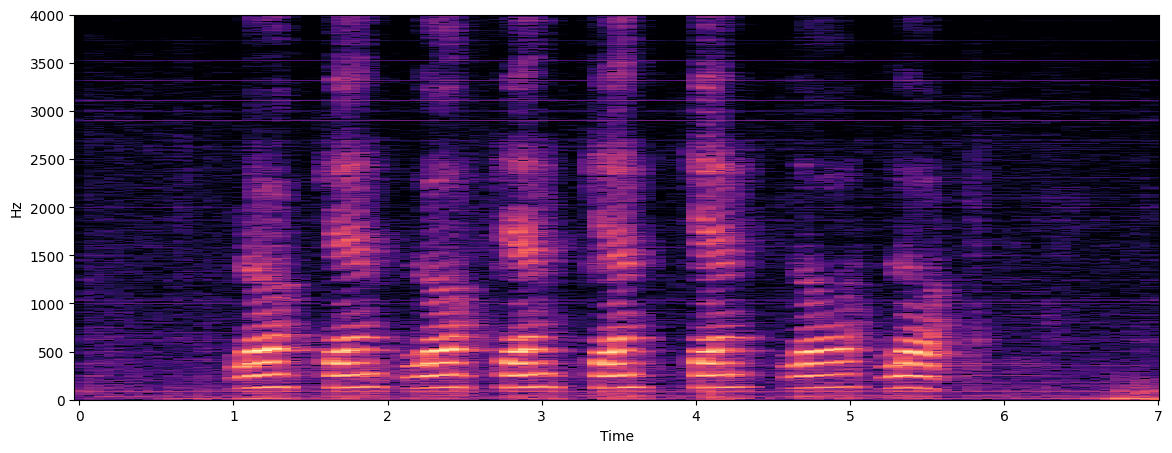

In [3]:
fig, ax = plt.subplots(figsize=(14, 5))

X = librosa.stft(y)                                     
Xdb = librosa.amplitude_to_db(np.abs(X), ref=np.max)


img = librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz', ax=ax)
ax.set_ylim(0, 4000)


## Task 3

C помощью функции [load_dataset](code-samples/audio_utils.py) загрузи датасет. \
Раздели его на train и test c параметрами `test_size=0.2`, `random_state=42`. \
Выведи количество файлов в train и test частях.

In [4]:
def load_dataset(directory: str):
   
    sr = None
    X, labels, files = [], [], []
    for f in glob(directory + "/*.wav"):
        filename = os.path.basename(f)
        name = filename[:-4]
        y = [int(label) for label in name.split("_")]
        x, sr = librosa.load(f)
        X.append(x)
        labels.append(y)
        files.append(filename)

    return X, labels, sr, files

In [5]:
from sklearn.model_selection import train_test_split
X, labels, sr, files = load_dataset('../datasets/waves_yesno 2')
X_train, X_test, Y_train, Y_test, files_train, files_test = train_test_split(X, labels, files, random_state=42, 
                                                                             test_size=0.2)
print('В обучающей выборке:', len(files_train), 'файлов \nВ тестовой выборке:', len(files_test), 'файлов')


В обучающей выборке: 47 файлов 
В тестовой выборке: 12 файлов


## Task 4

Наши аудио записи содержат как речь человека, так и молчание. Для каждой записи нам нужно определить сегменты записи, 
где человек молчит, а где произносит слова. \
Эта задача называется [Voice Activity Detection (VAD)](https://ru.wikipedia.org/wiki/Voice_Activity_Detection).
Придумайте или найдите метод, по которому можно распознавать участки с речью на аудио записи.

Например:
Запись '0_0_0_1_0_1_1_0.wav' содержит 137592 отсчетов. Сегменты с речью для этой записи (Отмечены красным):
[[23996, 32539],
 [35410, 44925],
 [49493, 57410],
 [60458, 68635],
 [73308, 81278],
 [84001, 91942],
 [97381, 104166],
 [109018, 115573]] 
![sftp](../misc/images/vad.png)

Выведи несколько примеров работы твоего VAD-алгоритма, по аналогии с примером, для других аудио записей. Попробуй добиться
наилучшего качества нахождения речи.

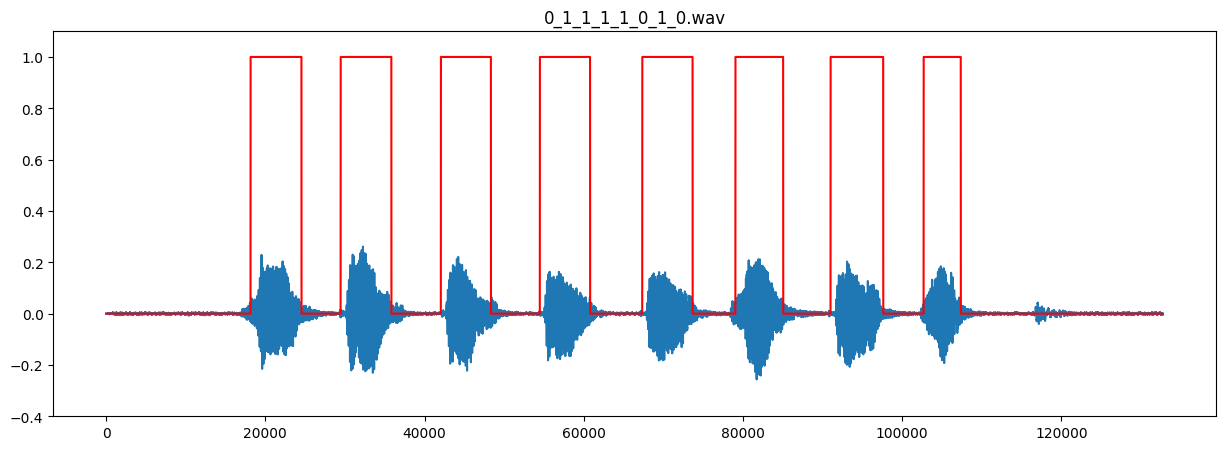

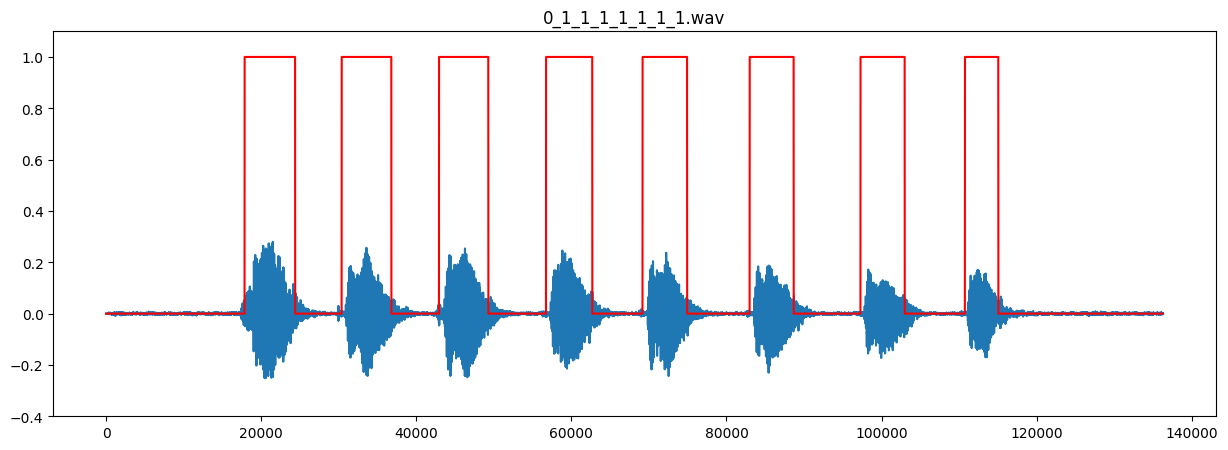

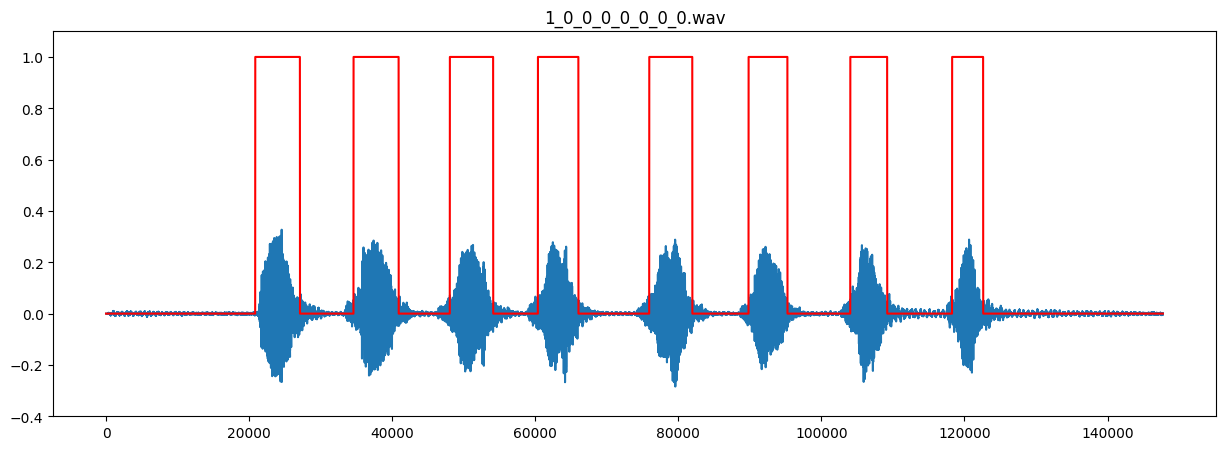

In [6]:
vad_segments = [librosa.effects.split( # список списков речевых меток
    sample, top_db=12, frame_length=2400, hop_length=12) for sample in X] #подбор параметров

file_start, file_end = 29, 32  # Выбор нескольких примеров
for file in range(file_start, file_end):
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(X[file], label='Original signal')
    X_act = np.zeros(int(len(X[file])))
    for segment in vad_segments[file]:
        X_act[segment[0]:segment[1]] = 1
    ax.plot(X_act, color='red', label='Voice detected')
    ax.set_ylim(-0.4, 1.1)
    ax.set_title(files[file])

## Task 5

После того как мы узнали сегменты аудио с речью, то можно перейти к самой задаче классификации. \
Внимательно изучи функцию [make_dataset](code-samples/audio_utils.py). С помощью этой функции cгенерируй X, Y для train и test выборок.
Затем попробуй обучить различные классификаторы. Например, SVM или LogisticRegression.
Измерь точность (accuracy) классификации на тестовой выборке.

In [7]:
def make_dataset(samples, labels, vad_segments):
    """

    :param samples: Список аудио сигналов
    :param labels: Список меток (Например для файла '0_0_0_1_0_1_1_0.wav': [0, 0, 0, 1, 0, 1, 1, 0])
    :param vad_segments: Список сегментов для каждого аудио сигнала вида:
        [
            [[23996, 32539], [35410, 44925], ...,],
            [[22141, 30259], [34917, 42695], ...,],
            ...
        ]
    :return:
    """
    X, y = [], []
    # Проходим по каждому аудио сигналу
    for sample in range(len(samples)):
        # В аудио сигнале проходим по каждому сегменту с речью
        for segment in range(len(vad_segments[sample]) - 1):
            start = vad_segments[sample][segment][0]  # Начало сегмента
            stop = vad_segments[sample][segment][1]  # Конец сегмента
            voice = samples[sample][start:stop]  # Отрезаем сегмент с речью из аудио сигнала и применяем stft
            stft = librosa.stft(voice).mean(axis=1)
            stft_db = librosa.amplitude_to_db(abs(stft))

            X.append(stft_db)  # Добавляем спектрограмму с речью
            y.append(labels[sample][segment])  # Добавляем метку для этой спектрограммы

    return np.array(X), np.array(y)

In [8]:


import warnings
warnings.filterwarnings("ignore", category=UserWarning)
X5, y5 = make_dataset(X, labels, vad_segments)
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size=0.2, 
                                                        random_state=42)
from sklearn import svm
from sklearn.metrics import accuracy_score

clf_svm = svm.SVC(kernel='rbf', random_state=42)
clf_svm.fit(X5_train, y5_train)
y_pred_svm = clf_svm.predict(X5_test)
sc_svm = accuracy_score(y5_test, y_pred_svm)
print('Svm accuracy на тестовой выборке:', sc_svm)

from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=5).fit(X5_train, y5_train) 
y_pred_dtc = tree.predict(X5_test)
sc_dtc = accuracy_score(y5_test, y_pred_dtc)
print('DecisionTreeClassifier accuracy на тестовой выборке модели дерева решений:', sc_dtc)



Svm accuracy на тестовой выборке: 0.9879518072289156
DecisionTreeClassifier accuracy на тестовой выборке модели дерева решений: 0.9397590361445783
